In [20]:
import os
import numpy as np
from PIL import Image
from patchify import patchify
import rasterio
from rasterio.windows import Window
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
import segmentation_models as sm
from skimage.util import img_as_ubyte
from skimage.transform import resize
from rasterio.plot import reshape_as_image

root_directory = 'experiment_with_SAR_data/'
patch_size = 256
scaler = MinMaxScaler()



In [21]:
image_dataset = []
scaler = MinMaxScaler()

for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'images':
        images = [f for f in files if f.endswith(".tif")]  # Filter only TIFF files
        for image_name in images:
            with rasterio.open(os.path.join(path, image_name)) as src:
                width = src.width
                height = src.height

                for row in range(0, height, patch_size):
                    for col in range(0, width, patch_size):
                        window = Window(col, row, min(patch_size, width - col), min(patch_size, height - row))
                        image_data = src.read(window=window)
                        image_data = reshape_as_image(image_data)  # Convert to (H, W, C)

                        if image_data.shape[0] == patch_size and image_data.shape[1] == patch_size:
                            image_data_scaled = scaler.fit_transform(image_data.reshape(-1, image_data.shape[-1])).reshape(image_data.shape)
                            image_dataset.append(image_data_scaled)
image_dataset = np.array(image_dataset)
image_dataset.shape

(112, 256, 256, 3)

In [30]:
# mask_dataset = []

# for path, subdirs, files in os.walk(root_directory):
#     dirname = path.split(os.path.sep)[-1]
#     if dirname == 'masks':
#         masks = [f for f in files if f.endswith(".tif")]  # Filter only PNG files
#         for mask_name in masks:
#             with rasterio.open(os.path.join(path, mask_name)) as src:
#                 width = src.width
#                 height = src.height

#                 for row in range(0, height, patch_size):
#                     for col in range(0, width, patch_size):
#                         window = Window(col, row, min(patch_size, width - col), min(patch_size, height - row))
#                         mask_data = src.read(window=window)
#                         mask_data = reshape_as_image(mask_data)  # Convert to (H, W, C)

#                         if mask_data.shape[0] == patch_size and mask_data.shape[1] == patch_size:
#                             mask_dataset.append(mask_data)

# mask_dataset = np.array(mask_dataset)
# mask_dataset.shape



# RUN THIS IF YOU WANT TO WRITE MASK CHUNCKS AS TIFF FILES
import os
import rasterio
from rasterio.windows import Window
import numpy as np

mask_dataset = []
chunk_extents = []
chunk_metadata = []
output_directory = "Mask"  # Change this to the directory where you want to save the chunks

for path, subdirs, files in os.walk(root_directory):
    dirname = path.split(os.path.sep)[-1]
    if dirname == 'masks':
        masks = [f for f in files if f.endswith(".tif")]  # Filter only TIFF files
        for mask_name in masks:
            with rasterio.open(os.path.join(path, mask_name)) as src:
                width = src.width
                height = src.height
                metadata = src.meta  # Retrieve metadata from the original image

                for row in range(0, height, patch_size):
                    for col in range(0, width, patch_size):
                        window = Window(col, row, min(patch_size, width - col), min(patch_size, height - row))
                        mask_data = src.read(window=window)
                        mask_data = reshape_as_image(mask_data)  # Convert to (H, W, C)

                        if mask_data.shape[0] == patch_size and mask_data.shape[1] == patch_size:
                            mask_dataset.append(mask_data)
                            
                            # Calculate extent of the chunk
                            chunk_extent = (col, row, col + patch_size, row + patch_size)
                            chunk_extents.append(chunk_extent)
                            
                            # Store metadata for the chunk
                            chunk_metadata.append(metadata)

                            # Save the chunk as a TIFF image
                            output_path = os.path.join(output_directory, f"chunk_{len(mask_dataset)}.tif")
                            with rasterio.open(
                                output_path,
                                'w',
                                driver='GTiff',
                                height=mask_data.shape[0],
                                width=mask_data.shape[1],
                                count=1,  # Number of bands
                                dtype=mask_data.dtype,
                                crs=metadata['crs'],
                                transform=src.window_transform(window),
                            ) as dst:
                                dst.write(mask_data.squeeze(), 1)  # Remove the extra dimension before writing

chunk_dataset = np.array(mask_dataset)
#chunk_extents = np.array(chunk_extents)
#chunk_metadata = np.array(chunk_metadata)
#chunk_extents

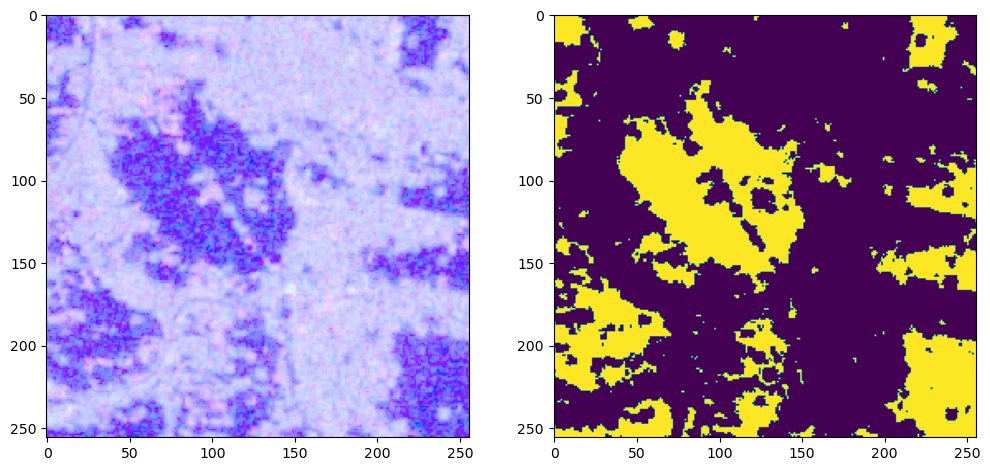

In [31]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)
mask_dataset.shape

#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 1)))
plt.show()

In [32]:
labels = []
for i in range(mask_dataset.shape[0]):
    # Assuming mask_dataset[i] has shape (height, width), and values 0 and 1
    label = mask_dataset[i]
    labels.append(label)

# Convert list to numpy array
labels = np.array(labels)
labels = np.expand_dims(labels, axis=3)
labels = labels[:, :, :, 0]
#x = np.squeeze(labels)

print("Unique labels in label dataset are: ", np.unique(labels))
print("Shape of labels array:", labels.shape)
n_classes = len(np.unique(labels))
from keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)
labels_cat.shape


Unique labels in label dataset are:  [0 1]
Shape of labels array: (112, 256, 256, 1)


(112, 256, 256, 2)

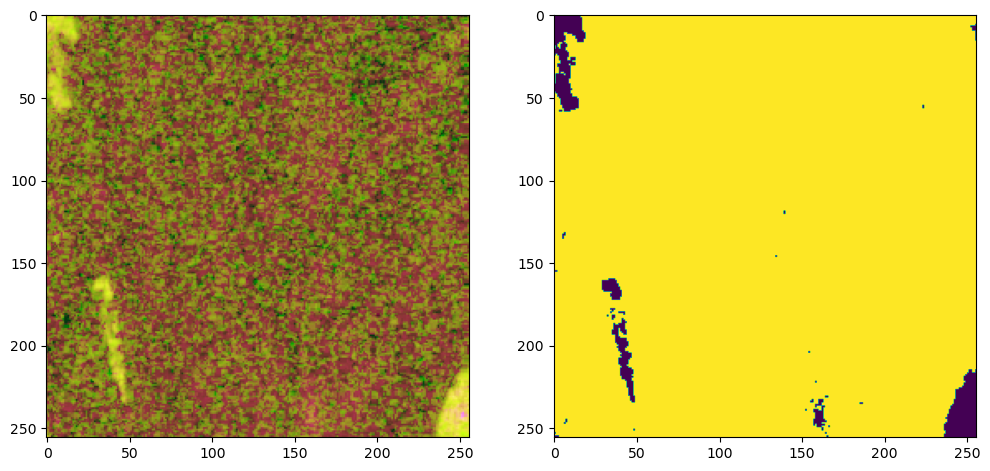

In [33]:
#Another Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(image_dataset[image_number])
plt.subplot(122)
plt.imshow(labels[image_number][:,:,0])
plt.show()

# DEFINE UNET AND TRAINED THE MODEL

In [34]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import MeanIoU

from simple_multi_unet_model_SAR import multi_unet_model, jacard_coef
# Prepare data for training
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size=0.20, random_state=42)

# Define model
n_classes = 2
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]



weights = [0.50, 0.50]
dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss) 

metrics=['accuracy', MeanIoU(num_classes=n_classes)]

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=metrics)
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
model.summary()

# Train model
history = model.fit(X_train, y_train, 
                    batch_size=16, 
                    verbose=1, 
                    epochs=20, 
                    validation_data=(X_test, y_test), 
                    shuffle=False)

# Save model
model.save('models/satellite_binary_unet_20epochs.hdf5')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 256, 256, 16  448         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 256, 256, 16  0           ['conv2d_19[0][0]']              
                                )                                                           

# PLOT LOSS

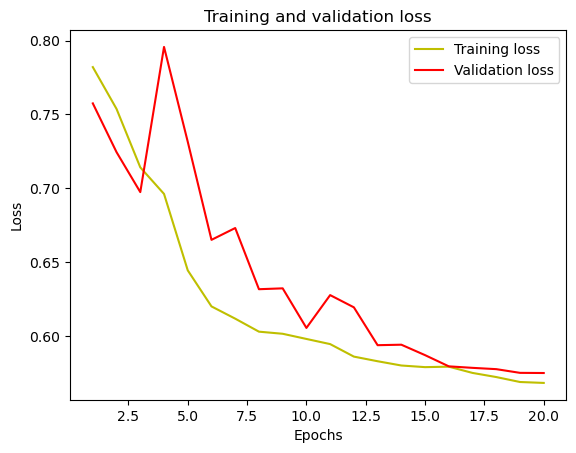

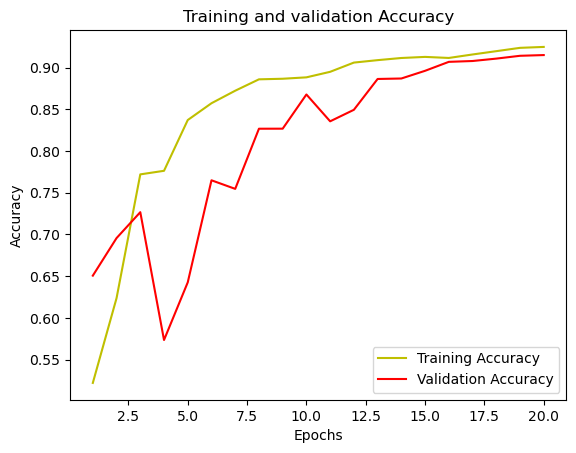

In [35]:
#plot the training and validation accuracy and loss at each epoch
history = history
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy at each epoch
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# IMPORT TRAINED MODEL AND PREDICT FOR IMAGES

1/1 [==============================] - 1s 897ms/step
Mean IoU = 0.8412174
1/1 [==============================] - 0s 63ms/step


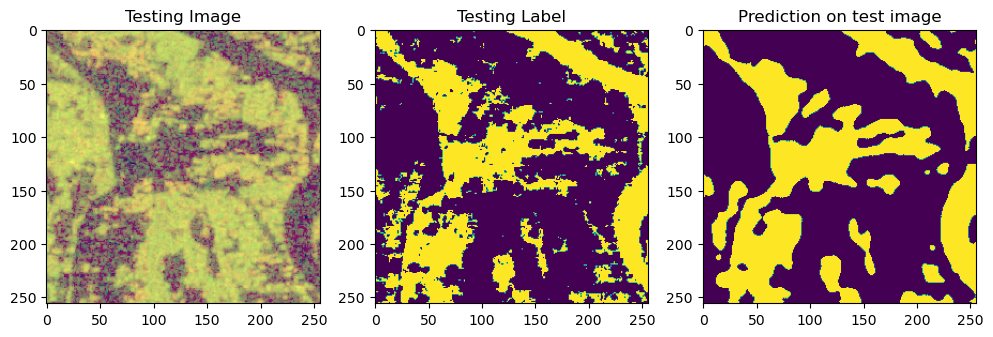

In [36]:
from keras.models import load_model
##################################
from keras.models import load_model
model = load_model("models/satellite_binary_unet_20epochs.hdf5",
                   custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                   'jacard_coef':jacard_coef})

#IOU
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)
y_test_argmax=np.argmax(y_test, axis=3)


#Using built in keras function for IoU
from keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

#######################################################################
#Predict on a few images

import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test_argmax[test_img_number]
#test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

#####################################################################

# SAVE IMAGES IN FOLDER

In [37]:
# Load the trained model
model = load_model("models/satellite_binary_unet_20epochs.hdf5",
                   custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                                   'jacard_coef': jacard_coef})

# Path to the folder where predicted masks will be saved
output_folder = r"C:\Varun\GA Work\Unet_Work\Keras\archive\Predicted_SAR"
os.makedirs(output_folder, exist_ok=True)

# Assuming you have obtained the georeferencing information (transform and CRS) earlier
# You need to replace the below lines with your code to obtain transform and CRS
transform = src.transform
crs = src.crs

# Predict for all images in X_test and save as TIFF
for i in range(len(image_dataset)):
    test_img = image_dataset[i]
    test_img_input = np.expand_dims(test_img, 0)
    prediction = model.predict(test_img_input)
    predicted_img = np.argmax(prediction, axis=3)[0,:,:]

    # Define the output metadata for the predicted mask
    meta = {
        'driver': 'GTiff',
        'dtype': rasterio.uint8,  # Set the data type to uint8
        'count': 1,
        'width': predicted_img.shape[1],
        'height': predicted_img.shape[0],
        'crs': crs,
        'transform': transform
    }

    # Convert predicted_img to uint8
    predicted_img_uint8 = predicted_img.astype(np.uint8)

    # Save the predicted mask as TIFF
    output_path = os.path.join(output_folder, f"predicted_mask_{i}.tif")
    with rasterio.open(output_path, 'w', **meta) as dst:
        dst.write(predicted_img_uint8, 1)

1/1 [==============================] - 0s 65ms/step


IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed